# 2D MT forward modelling

## Learning goals

- Identify Transverse Electric (TE) and Transverse Magnetic (TM) modes.
- Understand how to design mesh. 
- Understand **spatial features** of the transfer function in the form of apparent resistivity and phase
- Explore how the transfer function varies with **frequency**


In [1]:
import discretize
from discretize import utils as dis_utils
from SimPEG.electromagnetics import natural_source as nsem
from SimPEG import utils, maps
import numpy as np
import matplotlib.pyplot as plt
from pymatsolver import Pardiso as Solver
from geoana.em.fdem import skin_depth
from matplotlib.colors import LogNorm
import matplotlib
matplotlib.rcParams['font.size'] = 14
import warnings
warnings.filterwarnings("ignore")

## Step 1: Generate an MT survey

In [2]:
d_station = 4 * 1e3
n_rx = 26
x = np.arange(n_rx) * d_station - 50 * 1e3
lx = x.max() - x.min()
rx_locs = np.c_[x, np.zeros(n_rx)]
frequencies = np.logspace(-2, 2, 20)
n_freq = len(frequencies)

## Step 2: Discretize the domain using a 2D `Tensor` Mesh

In [6]:
def generate_2d_mesh_for_mt(
    rx_locs, frequencies, sigma_background, 
    z_factor_max=5, 
    z_factor_min=5,
    pfz_down = 1.2,
    pfz_up = 1.5,
    npadz_up = 5,
    x_factor_max = 2,
    spacing_factor = 4,
    pfx = 1.5,
    n_max=1000
):
    # Setting the cells in depth dimension
    f_min = frequencies.min()
    f_max = frequencies.max()
    dz_min = np.round(skin_depth(f_max, sigma_background) / z_factor_max) 
    lz = skin_depth(sigma_background, f_min) * z_factor_max
    # Setting the domain length in z-direction
    for nz_down in range(n_max):
        hz_down = dz_min*pfz_down**np.arange(nz_down)[::-1]
        if hz_down.sum()>lz:
            break
    hz_up = [(dz_min, npadz_up, pfz_up)]
    hz_up = dis_utils.unpack_widths(hz_up)
    hz = np.r_[hz_down, hz_up]   
    # Setting the cells in lateral dimension
    d_station = np.diff(rx_locs[:,0]).min()
    dx_min = np.round(d_station/spacing_factor)
    lx = rx_locs[:,0].max() - rx_locs[:,0].min()
    ncx = int(lx / dx_min)
    lx_pad = skin_depth(sigma_background, f_min) * x_factor_max
    for npadx in range(n_max):
        hx_pad = dis_utils.meshTensor([(dx_min, npadx, -pfx)])
        if hx_pad.sum()>lx_pad:
            break
    hx = [(dx_min, npadx, -pfx), (dx_min, ncx), (dx_min, npadx, pfx)]  
    
    mesh = discretize.TensorMesh([hx, hz])
    mesh.origin = np.r_[-mesh.hx[:npadx].sum()+rx_locs[:,0].min(), -hz_down.sum()]   
    print (mesh)
    return mesh
mesh = generate_2d_mesh_for_mt(rx_locs, frequencies, 1e-2)


  TensorMesh: 4,720 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    118   -162,330.08    162,330.08  1,000.00 38,443.36    1.50
   y     40   -297,782.46      1,997.91    101.00 49,714.58    1.50




<AxesSubplot:xlabel='x1', ylabel='x2'>

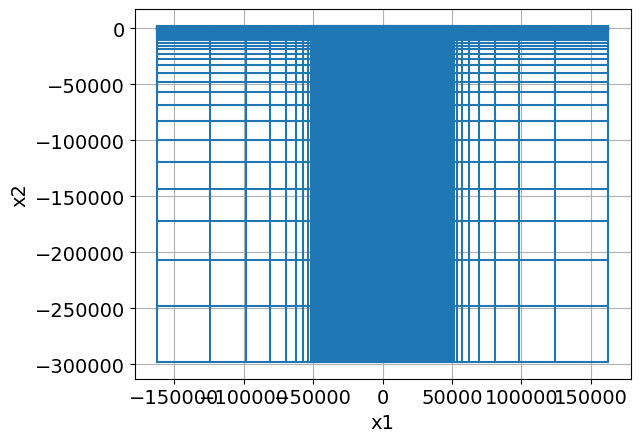

In [7]:
mesh.plot_grid()

## Step 3: Create a conductivity model

In [25]:
sigma_background = 1e-2
sigma_block = 1e0
sigma_air = 1e-8

cells = mesh.cell_centers
sigma = np.ones(mesh.n_cells) * sigma_background
blk_ind = utils.model_builder.getIndicesBlock(np.r_[-10000, -5000], np.r_[10000, -10000], cells)
sigma[blk_ind] = sigma_block
sigma[cells[:, -1] >= 0] = sigma_air

Text(0, 0.5, 'Elevation (m)')

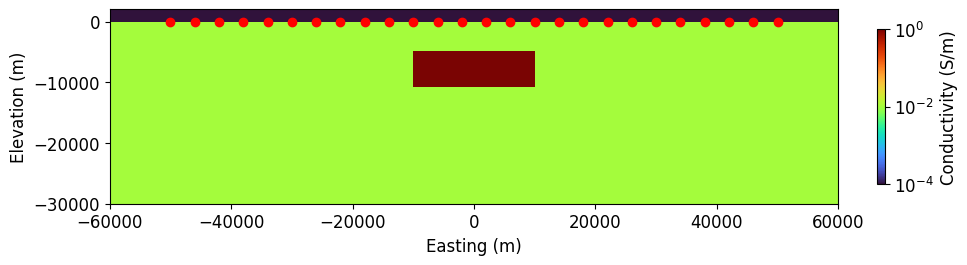

In [26]:
fig, ax = plt.subplots(1,1, figsize=(10, 10))
grid= False
out = mesh.plot_image(
    sigma, grid=grid, ax=ax, pcolor_opts={'norm':LogNorm(vmin=1e-4, vmax=1), 'cmap':'turbo'},
    range_x=(-60000, 60000), range_y=(-30000, 2000)
)
ax.plot(rx_locs[:,0], rx_locs[:,1], 'ro')
cb = plt.colorbar(out[0], fraction=0.01)
cb.set_label("Conductivity (S/m)")
ax.set_aspect(1)
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Elevation (m)")


## Step 3: Setup `Survey` and `Simulation`

In [10]:
# simulation class for TE mode
rx_list_tm = [
    nsem.receivers.PointNaturalSource(
        rx_locs, orientation="xy", component="apparent_resistivity"
    ),
    nsem.receivers.PointNaturalSource(
        rx_locs, orientation="xy", component="phase"
    ),
]
src_list_tm = [nsem.sources.Planewave(rx_list_tm, frequency=f) for f in frequencies]
survey_tm = nsem.Survey(src_list_tm)

sim_tm= nsem.simulation.Simulation2DElectricField(
    mesh,
    survey=survey_tm,
    sigma=sigma,
    solver=Solver,
)

# simulation class for TE mode
rx_list_te = [
    nsem.receivers.PointNaturalSource(
        rx_locs, orientation="yx", component="apparent_resistivity"
    ),
    nsem.receivers.PointNaturalSource(
        rx_locs, orientation="yx", component="phase",        
    ),       
]
src_list_te = [nsem.sources.Planewave(rx_list_te, frequency=f) for f in frequencies]
survey_te = nsem.Survey(src_list_te)

sim_te = nsem.simulation.Simulation2DMagneticField(
    mesh,
    survey=survey_te,
    sigma=sigma,
    solver=Solver,
)

## Step 4: Run forward modelling

In [11]:
f_te = sim_te.fields()
pred_te = sim_te.dpred(f=f_te)
f_tm = sim_tm.fields()
pred_tm = sim_tm.dpred(f=f_tm)

In [12]:
# extract fields
i_freq = 0 
e_te = f_te[src_list_te[i_freq], 'e']
h_te = f_te[src_list_te[i_freq], 'h']
e_tm = f_tm[src_list_tm[i_freq], 'e']
h_tm = f_tm[src_list_tm[i_freq], 'h']

Text(0, 0.5, 'Elevation (m)')

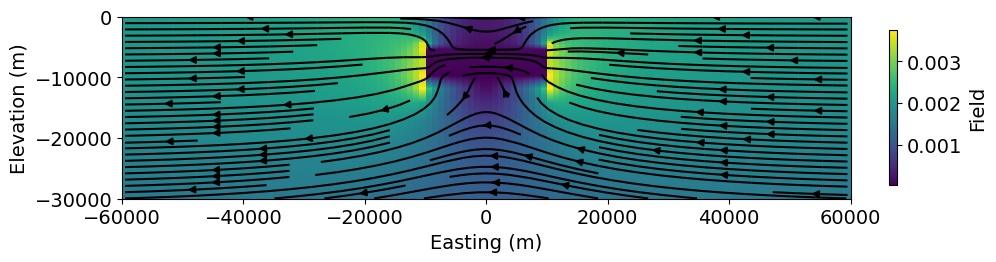

In [13]:
fig, ax = plt.subplots(1,1, figsize=(10, 10))
out = mesh.plot_image(e_tm.real, v_type='E', view='vec', ax=ax, range_x=(-60000, 60000), range_y=(-30000, 0))
cb = plt.colorbar(out[0], fraction=0.01)
cb.set_label("Field")
ax.set_aspect(1)
ax.set_ylim(-30000, 0)
ax.set_xlim(-60000, 60000)
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Elevation (m)")

Text(0, 0.5, 'Elevation (m)')

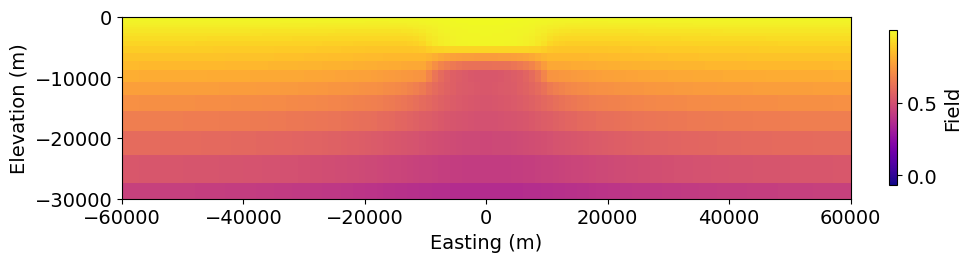

In [14]:
fig, ax = plt.subplots(1,1, figsize=(10, 10))
out = mesh.plot_image(
    h_tm.real, v_type='CC', ax=ax, range_x=(-60000, 60000), range_y=(-30000, 0),
    pcolor_opts={'cmap':'plasma'}
)
cb = plt.colorbar(out[0], fraction=0.01)
cb.set_label("Field")
ax.set_aspect(1)
ax.set_ylim(-30000, 0)
ax.set_xlim(-60000, 60000)
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Elevation (m)")

Text(0, 0.5, 'Elevation (m)')

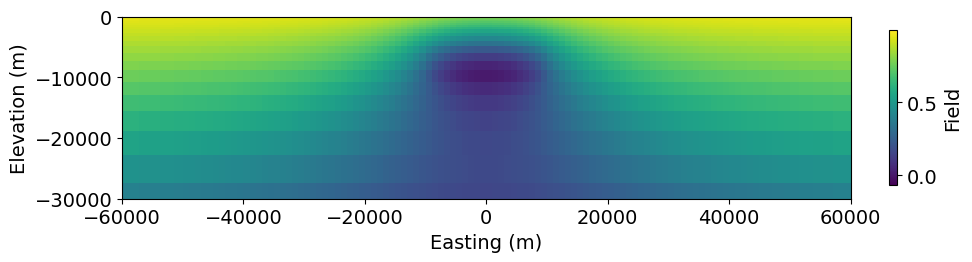

In [15]:
fig, ax = plt.subplots(1,1, figsize=(10, 10))
out = mesh.plot_image(e_te.real, v_type='CC', ax=ax, range_x=(-60000, 60000), range_y=(-30000, 0))
cb = plt.colorbar(out[0], fraction=0.01)
cb.set_label("Field")
ax.set_aspect(1)
ax.set_ylim(-30000, 0)
ax.set_xlim(-60000, 60000)
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Elevation (m)")

Text(0, 0.5, 'Elevation (m)')

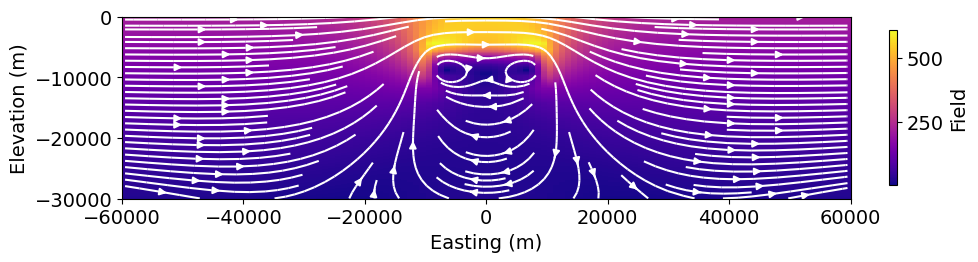

In [16]:
fig, ax = plt.subplots(1,1, figsize=(10, 10))
out = mesh.plot_image(
    h_te.real, v_type='E', view='vec', ax=ax, range_x=(-60000, 60000), range_y=(-30000, 0),
    pcolor_opts={'cmap':'plasma'}, stream_opts={'color':'w'}
)
cb = plt.colorbar(out[0], fraction=0.01)
cb.set_label("Field")
ax.set_aspect(1)
ax.set_ylim(-30000, 0)
ax.set_xlim(-60000, 60000)
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Elevation (m)")

In [17]:
PRED_te = pred_te.reshape((n_freq, 2, n_rx))
PRED_tm = pred_tm.reshape((n_freq, 2, n_rx))

rho_app_te = PRED_te[:,0,:]
rho_app_tm = PRED_tm[:,0,:]

phase_te = PRED_te[:,1,:]
phase_tm = PRED_tm[:,1,:]

In [18]:
from ipywidgets import widgets, interact

In [19]:
import matplotlib
matplotlib.rcParams['font.size'] = 12
def foo_te(kk, mode):
    fig, axs = plt.subplots(2, 1, figsize=(8, 5))
    for i_freq in range(kk):
        ax1, ax2 = axs
        if mode == 'TE':
            ax1.semilogy(rx_locs[:,0], rho_app_te[i_freq,:], '-', label='TE-AppRes.', color='C0')
            ax2.plot(rx_locs[:,0], phase_te[i_freq,:], '-', label='TE-Pha.', color='C0')
        elif mode == 'TM':
            ax1.semilogy(rx_locs[:,0], rho_app_tm[i_freq,:], '-', label='TM-AppRes.', color='C1')
            ax2.plot(rx_locs[:,0], phase_tm[i_freq,:]+180, '-', label='TM-Pha.', color='C1')
        ax1.set_title("Frequency at {:.1e} Hz".format(frequencies[i_freq]))
        ax1.set_xticklabels([])
        ax1.set_ylim(1, 1e3) 
        ax2.set_ylim(0, 90)
        ax1.set_ylabel("Apparent resistivity (Ohm-m)")
        ax2.set_ylabel("Phase (degree)")

In [20]:
interact(
    foo_te, 
    kk=widgets.IntSlider(min=1, max=len(frequencies), value=1, continuous_update=True),
    mode=widgets.RadioButtons(options=['TE', 'TM'])
)

interactive(children=(IntSlider(value=1, description='kk', max=20, min=1), RadioButtons(description='mode', op…

<function __main__.foo_te(kk, mode)>

In [21]:
def foo_sounding(i_sounding):
    fig, axs = plt.subplots(2, 1, figsize=(8, 6))
    ax1, ax2 = axs
    ax1.loglog(1./frequencies, rho_app_te[:,i_sounding], '.-', label='TE-AppRes.')
    ax1.loglog(1./frequencies, rho_app_tm[:,i_sounding], '.-', label='TM-AppRes.')
    ax1.legend()
    ax1.set_ylim(1, 1e4)

    ax2.semilogx(1./frequencies, phase_te[:,i_sounding], '.-', label='TE-Pha.')
    ax2.semilogx(1./frequencies, phase_tm[:,i_sounding]+180, '.-', label='TM-Pha.')
    ax2.set_ylim(0, 90)
    ax2.legend()
    for ax in axs:
        ax.grid(True, which='both', alpha=0.3)
    ax1.set_ylabel("Resistivity (Ohm-m)")
    ax2.set_ylabel("Phase (degree)")
    ax2.set_xlabel('Period (s)')
    ax1.set_title("Easting at {:.0f} m".format(rx_locs[i_sounding, 0]))
interact(
    foo_sounding, 
    i_sounding=widgets.IntSlider(min=1, max=len(frequencies), value=1, continuous_update=True),
    mode=widgets.RadioButtons(options=['TE', 'TM'])
)

interactive(children=(IntSlider(value=1, description='i_sounding', max=20, min=1), Output()), _dom_classes=('w…

<function __main__.foo_sounding(i_sounding)>

Text(0, 0.5, 'Elevation (m)')

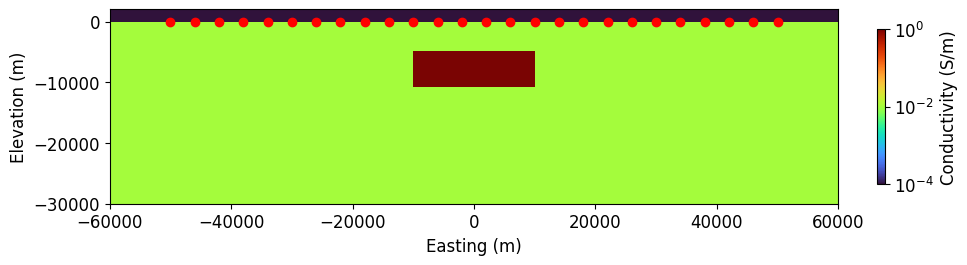

In [22]:
fig, ax = plt.subplots(1,1, figsize=(10, 10))
grid= False
out = mesh.plot_image(
    sigma, grid=grid, ax=ax, pcolor_opts={'norm':LogNorm(vmin=1e-4, vmax=1), 'cmap':'turbo'},
    range_x=(-60000, 60000), range_y=(-30000, 2000)
)
ax.plot(rx_locs[:,0], rx_locs[:,1], 'ro')
cb = plt.colorbar(out[0], fraction=0.01)
cb.set_label("Conductivity (S/m)")
ax.set_aspect(1)
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Elevation (m)")


In [23]:
noise_rho_app_te = 0.05 * abs(rho_app_te) * np.random.randn(len(frequencies), n_rx)
noise_rho_app_tm = 0.05 * abs(rho_app_tm) * np.random.randn(len(frequencies), n_rx)
noise_phase_te = 2 * np.ones_like(phase_te) * np.random.randn(len(frequencies), n_rx)
noise_phase_tm = 2 * np.ones_like(phase_tm) * np.random.randn(len(frequencies), n_rx)

In [24]:
# This could have been better if we could use MTpy
import dill 
output_results ={
    'rx_locs': rx_locs,
    'frequencies': frequencies,
    'app_rho_te': rho_app_te+noise_rho_app_te,
    'app_rho_tm': rho_app_tm+noise_rho_app_tm,
    'phase_te': phase_te+noise_phase_te,
    'phase_tm': phase_tm+noise_phase_tm,
    'mesh': mesh,
    'sigma': sigma
}
dill.dump(output_results, open("./synthetic_2d.pik", "wb"))